In [146]:
import pandas as pd
import numpy as np
import torch
device = torch.device('cuda')

In [158]:
from transformers import pipeline
classifier = pipeline("zero-shot-classification",model="tasksource/deberta-small-long-nli",device='cuda')

text = "one day I will see the world"
candidate_labels = ['travel', 'cooking', 'dancing']
classifier(text, candidate_labels)

Device set to use cuda
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


{'sequence': 'one day I will see the world',
 'labels': ['travel', 'dancing', 'cooking'],
 'scores': [0.8819176554679871, 0.09866907447576523, 0.019413240253925323]}

In [ ]:
def prediction(classifier,candidate_labels,texts):
    results_list = []
    for text in tqdm(texts, desc="Classifying texts"):
            result = classifier(text, candidate_labels)
            # Apply threshold to determine the label
            results_list.append(result)

### DATASET 1: BIAS_CORP

In [8]:
bcorp = pd.read_csv('bias_corp_racial.csv')
bcorp.head()

## bias == racial bias ( 0, 1, 2, 3, 4, 5)
## indicating their confidence in the bias score (1-10)

,text,bias_1,bias_2,bias_3,confidence_1,confidence_2,confidence_3,time_1,time_2,time_3,sentiment_score,source
0,"'' Democrats needed someone like Obama, half w...",4,3,2,4,3,5,82,94,295,0.205548,BB
1,'Greatest threat to the Black Famiky is the wh...,1,3,4,6,6,4,48,37,23,-0.189737,BB
2,"'In March, Black Lives Matter activists marche...",3,3,2,7,7,7,140,2495,75,-0.282843,BB
3,"'Rogue'' Chinese Virologist Joins Twitter, Pub...",5,4,3,8,9,7,3900,6838,85,-0.094491,BB
4,'What this means is he could have told black p...,2,3,3,8,7,6,9302,4203,43,-0.347440,BB


In [11]:
df = bcorp.copy()

# Function to compute the normalized confidence-weighted bias score
def compute_weighted_bias(row):
    # Extract bias and confidence scores
    bias_scores = np.array([row['bias_1'], row['bias_2'], row['bias_3']])
    confidence_scores = np.array([row['confidence_1'], row['confidence_2'], row['confidence_3']])
    
    # Normalize confidence scores so they sum to 1
    normalized_conf = confidence_scores / confidence_scores.sum()
    
    # Compute the weighted bias score
    weighted_bias = np.dot(bias_scores, normalized_conf)
    return weighted_bias

# Apply the function to compute weighted bias scores
df['weighted_bias'] = df.apply(compute_weighted_bias, axis=1)

# Determine true labels based on a threshold (e.g., weighted bias >= 3 is racist)
df['true_label'] = (df['weighted_bias'] >= 3).astype(int)

df.head()

,text,bias_1,bias_2,bias_3,confidence_1,confidence_2,confidence_3,time_1,time_2,time_3,sentiment_score,source,weighted_bias,true_label
0,"'' Democrats needed someone like Obama, half w...",4,3,2,4,3,5,82,94,295,0.205548,BB,2.916667,0
1,'Greatest threat to the Black Famiky is the wh...,1,3,4,6,6,4,48,37,23,-0.189737,BB,2.500000,0
2,"'In March, Black Lives Matter activists marche...",3,3,2,7,7,7,140,2495,75,-0.282843,BB,2.666667,0
3,"'Rogue'' Chinese Virologist Joins Twitter, Pub...",5,4,3,8,9,7,3900,6838,85,-0.094491,BB,4.041667,1
4,'What this means is he could have told black p...,2,3,3,8,7,6,9302,4203,43,-0.347440,BB,2.619048,0


In [13]:
texts = df['text'].tolist()
df['text'].tolist()[11]

' This kind of black genocide is supported by any blacks who are voting Democrat\n\n\n\nAnd you know what?'

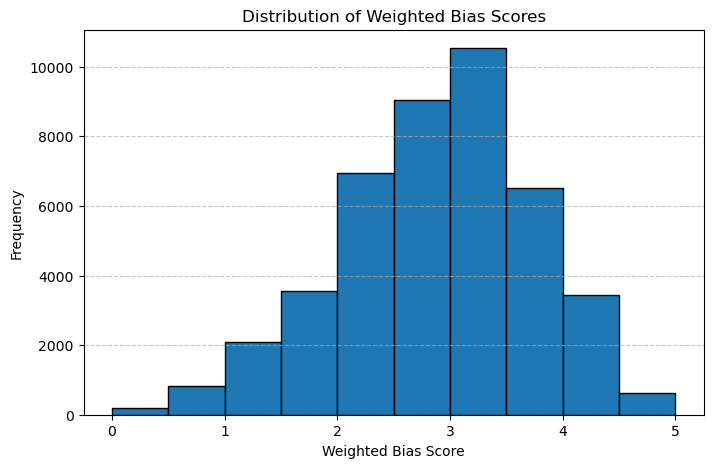

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.hist(df['weighted_bias'], bins=10, edgecolor='black')
plt.title('Distribution of Weighted Bias Scores')
plt.xlabel('Weighted Bias Score')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
df.head()

In [ ]:
#Calculate model accuracy
accuracy = (df['model_prediction'] == df['true_label']).mean()

# Display the results
print(df[['weighted_bias', 'true_label', 'model_prediction']])
print(f"\nModel Accuracy: {accuracy:.2f}")

In [17]:
text = "This kind of black genocide is supported by any blacks who are voting Democrat\n\n\n\nAnd you know what?"
candidate_labels = ['racism', 'not_racism']
classifier(text, candidate_labels)

{'sequence': 'This kind of black genocide is supported by any blacks who are voting Democrat\n\n\n\nAnd you know what?',
 'labels': ['racism', 'not_racism'],
 'scores': [0.917849600315094, 0.08215037733316422]}

In [19]:
from transformers import pipeline
from datasets import Dataset
import pandas as pd
from tqdm import tqdm

# Candidate labels
candidate_labels = ['racism', 'not_racism']

# Function to classify texts individually with tqdm for progress tracking
def classify_texts(texts, threshold=0.85):
    predicted_labels = []
    predicted_scores = []
    results_list = []
    for text in tqdm(texts, desc="Classifying texts"):
        result = classifier(text, candidate_labels)
        # Apply threshold to determine the label
        results_list.append(result)
        if result['scores'][0] >= threshold and result['labels'][0] == 'racism':
            predicted_labels.append('racism')
            predicted_scores.append(result['scores'][0])
        else:
            predicted_labels.append('not_racism')
            predicted_scores.append(result['scores'][0])
    return predicted_labels, predicted_scores, results_list

# Classify the texts
predicted_labels1, predicted_scores1, results = classify_texts(df['text'])

# Add predictions to the DataFrame
df['predicted_label'] = predicted_labels1
df['predicted_score'] = predicted_scores1

# Display the DataFrame with predictions
df.head()

Classifying texts: 100%|█████████████████████████████████████████████████████████| 43732/43732 [37:38<00:00, 19.37it/s]


,text,bias_1,bias_2,bias_3,confidence_1,confidence_2,confidence_3,time_1,time_2,time_3,sentiment_score,source,weighted_bias,true_label,predicted_label,predicted_score
0,"'' Democrats needed someone like Obama, half w...",4,3,2,4,3,5,82,94,295,0.205548,BB,2.916667,0,not_racism,0.267401
1,'Greatest threat to the Black Famiky is the wh...,1,3,4,6,6,4,48,37,23,-0.189737,BB,2.500000,0,not_racism,0.165571
2,"'In March, Black Lives Matter activists marche...",3,3,2,7,7,7,140,2495,75,-0.282843,BB,2.666667,0,not_racism,0.299196
3,"'Rogue'' Chinese Virologist Joins Twitter, Pub...",5,4,3,8,9,7,3900,6838,85,-0.094491,BB,4.041667,1,not_racism,0.106838
4,'What this means is he could have told black p...,2,3,3,8,7,6,9302,4203,43,-0.347440,BB,2.619048,0,not_racism,0.337929


In [119]:
print('True label counts: ',df['true_label'].value_counts())
print("Threshold score counts: ", df['predicted_label'].value_counts())

True label counts:  true_label
0    22622
1    21110
Name: count, dtype: int64
Threshold score counts:  predicted_label
not_racism    27916
racism        15816
Name: count, dtype: int64


In [25]:
results[:5]

[{'sequence': "'' Democrats needed someone like Obama, half white and half black.",
  'labels': ['racism', 'not_racism'],
  'scores': [0.7325993180274963, 0.2674006521701813]},
 {'sequence': "'Greatest threat to the Black Famiky is the white liberal'....",
  'labels': ['racism', 'not_racism'],
  'scores': [0.8344290852546692, 0.16557082533836365]},
 {'sequence': "'In March, Black Lives Matter activists marched to Lacey<U+00A1><U+00AF>s door in the wee hours of the morning <U+00A1><U+00AA> and Lacey<U+00A1><U+00AF>s husband confronted them with a gun and told them to leave.",
  'labels': ['racism', 'not_racism'],
  'scores': [0.700803816318512, 0.2991962432861328]},
 {'sequence': "'Rogue'' Chinese Virologist Joins Twitter, Publishes 'Smoking Gun' Evidence COVID-19 Created In Lab https://www.zerohedge.com/medical/rogue-chinese-virologist-joins-twitter-publishes-evidence-covid-19-created-lab",
  'labels': ['not_racism', 'racism'],
  'scores': [0.8931620121002197, 0.1068379282951355]},
 {'

In [55]:
with open("data.json", "w") as file:
    json.dump(results, file,indent=2)

In [71]:
import json

# Specify the file path of the JSON file
file_path = "output.json"  # Replace with your actual file path

# Load the JSON file into a Python list of dictionaries
with open(file_path, "r") as json_file:
    data = json.load(json_file)

results = json.loads(data)

In [127]:
threshold = 0.70
def set_label(results,threshold):
    predicted_labels = []
    predicted_scores = []
    for result in results:
        if result['scores'][0] >= threshold and result['labels'][0] == 'racism':
                predicted_labels.append('racism')
                predicted_scores.append(result['scores'][0])
        else:
            predicted_labels.append('not_racism')
            predicted_scores.append(result['scores'][1])
    return predicted_labels, predicted_scores

predicted_label, predicted_score = set_label(results,threshold)

In [129]:
df['predicted_label'] = predicted_label
df['predicted_score'] = predicted_score

Accuracy: 0.5232
F1 Score: 0.5226
Confusion Matrix:
[[11464 11158]
 [ 9695 11415]]


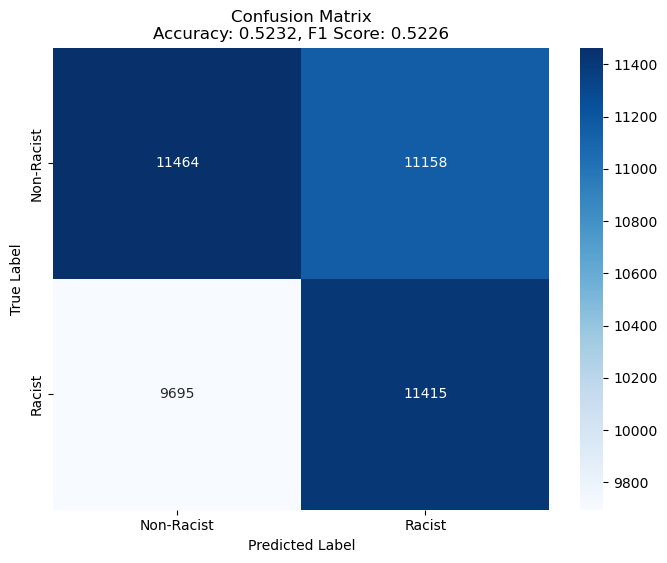

In [304]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

df['prediction'] = df['predicted_label'].map({"racism": 1, "not_racism": 0})
# Assuming df['true_label'] and df['prediction'] are defined
accuracy = accuracy_score(df['true_label'], df['prediction'])
f1 = f1_score(df['true_label'], df['prediction'])
conf_matrix = confusion_matrix(df['true_label'], df['prediction'])

# Display the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
ax = sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Racist", "Racist"], yticklabels=["Non-Racist", "Racist"])
ax.set_title(f"Confusion Matrix\nAccuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")
plt.show()


In [306]:
df.to_csv('deberta_biascorp.csv',index=False)

### DATASET 2: SAKREN

In [136]:
from datasets import load_dataset

sakren = load_dataset("sakren/twitter_racism_dataset")

In [138]:
sakren = sakren['train'].to_pandas()
sakren.head()

In [140]:
sakren.head()

,index,id,Text,Annotation,oh_label
0,5.767493e+17,5.767493e+17,@AAlwuhaib1977 Muslim mob violence against Hin...,racism,1
1,5.408905e+17,5.408905e+17,@Te4m_NiGhtM4Re http://t.co/5Ih7MkDbQG,none,0
2,5.678433e+17,5.678433e+17,@jncatron @isra_jourisra @AMPalestine Islamoph...,racism,1
3,5.766462e+17,5.766462e+17,"Finally I'm all caught up, and that sudden dea...",none,0
4,5.713492e+17,5.713492e+17,@carolinesinders @herecomesfran *hugs*,none,0


In [162]:
def prediction(classifier,candidate_labels,texts):
    results_list = []
    for text in tqdm(texts, desc="Classifying texts"):
            result = classifier(text, candidate_labels)
            # Apply threshold to determine the label
            results_list.append(result)
    return results_list

In [164]:
candidate_labels = ['racism','none']
results_sakren = prediction(classifier,candidate_labels,sakren['Text'])

Classifying texts: 100%|█████████████████████████████████████████████████████████| 13471/13471 [10:39<00:00, 21.08it/s]


In [166]:
results_sakren

[{'sequence': '@AAlwuhaib1977 Muslim mob violence against Hindus in Bangladesh continues in 2014. #Islam http://t.co/C1JBWJwuRc',
  'labels': ['racism', 'none'],
  'scores': [0.6656766533851624, 0.33432328701019287]},
 {'sequence': '@Te4m_NiGhtM4Re http://t.co/5Ih7MkDbQG',
  'labels': ['none', 'racism'],
  'scores': [0.812704861164093, 0.18729513883590698]},
 {'sequence': '@jncatron @isra_jourisra @AMPalestine Islamophobia is like the idea of Naziphobia. Islam is a religion of hate and it must be outlawed.',
  'labels': ['racism', 'none'],
  'scores': [0.5848799347877502, 0.41512009501457214]},
 {'sequence': "Finally I'm all caught up, and that sudden death cook off looks like it's gonna be intense #MKR",
  'labels': ['none', 'racism'],
  'scores': [0.7451400756835938, 0.25485989451408386]},
 {'sequence': '@carolinesinders @herecomesfran *hugs*',
  'labels': ['racism', 'none'],
  'scores': [0.5303603410720825, 0.46963971853256226]},
 {'sequence': 'Please, PLEASE start using "is your di

In [245]:
threshold = 0.6
def set_label(results,threshold):
    predicted_labels = []
    predicted_scores = []
    for result in results:
        if result['scores'][0] >= threshold and result['labels'][0] == 'racism':
                predicted_labels.append('racism')
                predicted_scores.append(result['scores'][0])
        else:
            predicted_labels.append('not_racism')
            predicted_scores.append(result['scores'][0])
    return predicted_labels, predicted_scores

predicted_sakren, predicted_score_sakren = set_label(results_sakren,threshold)

In [247]:
sakren['pred_label'] = predicted_sakren
sakren['pred_score'] = predicted_score_sakren

In [249]:
sakren.head()

,index,id,Text,Annotation,oh_label,pred_label,pred_score
0,5.767493e+17,5.767493e+17,@AAlwuhaib1977 Muslim mob violence against Hin...,racism,1,racism,0.665677
1,5.408905e+17,5.408905e+17,@Te4m_NiGhtM4Re http://t.co/5Ih7MkDbQG,none,0,not_racism,0.812705
2,5.678433e+17,5.678433e+17,@jncatron @isra_jourisra @AMPalestine Islamoph...,racism,1,not_racism,0.584880
3,5.766462e+17,5.766462e+17,"Finally I'm all caught up, and that sudden dea...",none,0,not_racism,0.745140
4,5.713492e+17,5.713492e+17,@carolinesinders @herecomesfran *hugs*,none,0,not_racism,0.530360


In [294]:
sakren['Annotation'].value_counts()
sakren['pred_label'].value_counts()

pred_label
not_racism    12290
racism         1181
Name: count, dtype: int64

In [298]:
sakren.to_csv('deberta_sakren.csv',index=False)

Accuracy: 0.8458
F1 Score: 0.3408
Confusion Matrix:
[[10857   644]
 [ 1433   537]]


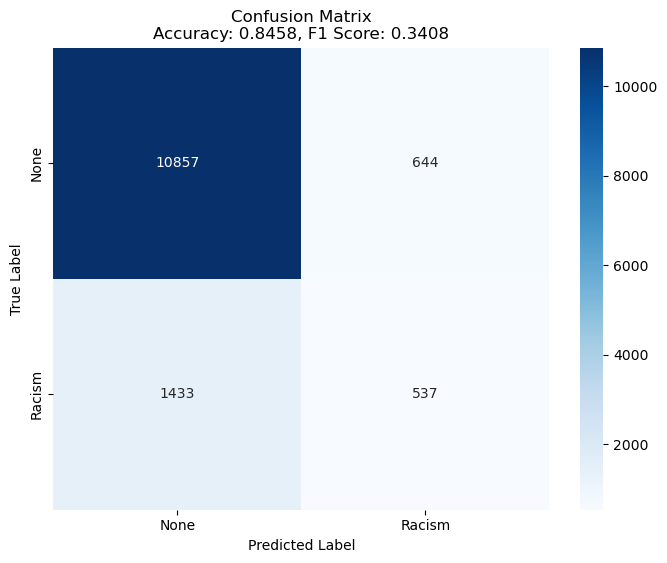

In [296]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

sakren['pred_label_binary'] = sakren['pred_label'].map({"not_racism": 0, "racism": 1})

# Calculate metrics
accuracy = accuracy_score(sakren['oh_label'], sakren['pred_label_binary'])
f1 = f1_score(sakren['oh_label'], sakren['pred_label_binary'])
conf_matrix = confusion_matrix(sakren['oh_label'], sakren['pred_label_binary'])

# Display metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
ax = sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
                 xticklabels=["None", "Racism"], yticklabels=["None", "Racism"])
ax.set_title(f"Confusion Matrix\nAccuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")
plt.show()


### DATASET 3: TWITTER RACISM DATASET

In [227]:
from datasets import load_dataset

ds = load_dataset("tweets-hate-speech-detection/tweets_hate_speech_detection")

In [231]:
twitter = ds['train'].to_pandas()

In [233]:
twitter.head()

,label,tweet
0,0,@user when a father is dysfunctional and is so...
1,0,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation


In [235]:
candidate_labels = ['racism','none']
results_twitter = prediction(classifier,candidate_labels,twitter['tweet'])

Classifying texts: 100%|█████████████████████████████████████████████████████████| 31962/31962 [24:28<00:00, 21.76it/s]


In [237]:
results_twitter[:5]

[{'sequence': '@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction.   #run',
  'labels': ['none', 'racism'],
  'scores': [0.7698680758476257, 0.23013187944889069]},
 {'sequence': "@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx.    #disapointed #getthanked",
  'labels': ['none', 'racism'],
  'scores': [0.8420562744140625, 0.1579437404870987]},
 {'sequence': 'bihday your majesty',
  'labels': ['none', 'racism'],
  'scores': [0.8584979176521301, 0.14150211215019226]},
 {'sequence': '#model   i love u take with u all the time in urð\x9f\x93±!!! ð\x9f\x98\x99ð\x9f\x98\x8eð\x9f\x91\x84ð\x9f\x91\x85ð\x9f\x92¦ð\x9f\x92¦ð\x9f\x92¦  ',
  'labels': ['none', 'racism'],
  'scores': [0.7178811430931091, 0.28211888670921326]},
 {'sequence': 'factsguide: society now    #motivation',
  'labels': ['none', 'racism'],
  'scores': [0.7852103114128113, 0.21478964388370514]}]

In [243]:
threshold = 0.7
def set_label(results,threshold):
    predicted_labels = []
    predicted_scores = []
    for result in results:
        if result['scores'][0] >= threshold and result['labels'][0] == 'racism':
                predicted_labels.append('racism')
                predicted_scores.append(result['scores'][0])
        else:
            predicted_labels.append('not_racism')
            predicted_scores.append(result['scores'][0])
    return predicted_labels, predicted_scores

predicted_label_twitter, predicted_score_twitter = set_label(results_twitter,threshold)
twitter['pred_label'] = predicted_label_twitter
twitter['pred_score'] = predicted_score_twitter
twitter.head()

,label,tweet,pred_label,pred_score
0,0,@user when a father is dysfunctional and is so...,not_racism,0.769868
1,0,@user @user thanks for #lyft credit i can't us...,not_racism,0.842056
2,0,bihday your majesty,not_racism,0.858498
3,0,#model i love u take with u all the time in ...,not_racism,0.717881
4,0,factsguide: society now #motivation,not_racism,0.785210


In [300]:
twitter.to_csv('deberta_twitter.csv',index=False)

Accuracy: 0.9325
F1 Score: 0.2726
Confusion Matrix:
[[29402   318]
 [ 1838   404]]


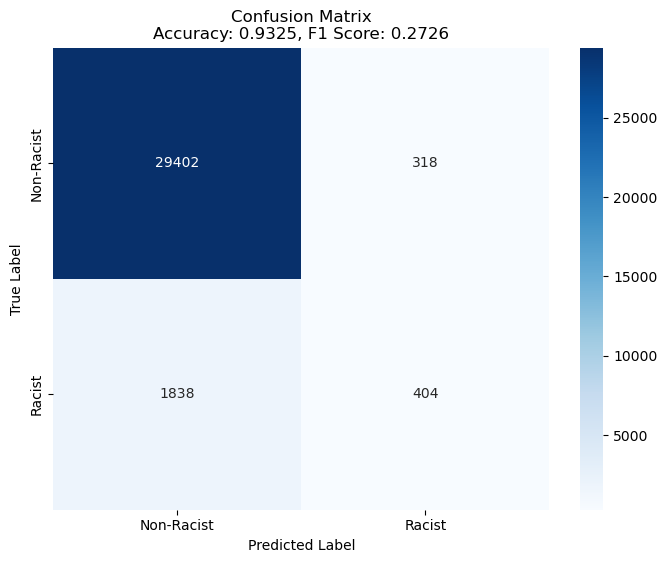

In [292]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Convert twitter['prediction'] to binary integer
twitter['prediction_binary'] = twitter['pred_label'].map({"racism": 1, "not_racism": 0})

# Calculate Metrics for 'racism' only
accuracy = accuracy_score(twitter['label'], twitter['prediction_binary'])
f1 = f1_score(twitter['label'], twitter['prediction_binary'])
conf_matrix = confusion_matrix(twitter['label'], twitter['prediction_binary'])

# Display the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

# Plot the Confusion Matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
ax = sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
                 xticklabels=["Non-Racist", "Racist"], yticklabels=["Non-Racist", "Racist"])
ax.set_title(f"Confusion Matrix\nAccuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")
plt.show()

### DATASET 4: KAGGLE

In [258]:
kaggle_racism = pd.read_csv("D:/OneDrive - University of Georgia/UGA/Dr. Itai/Racism/racism_kaggle/racism1.csv",low_memory=False)

In [260]:
kaggle = kaggle_racism[['date','tweet','cleanText','TextBlob Sentiment']]
kaggle.head()

,date,tweet,cleanText,TextBlob Sentiment
0,6/3/2021,@HyperSnoc @Echo31334604 @im_not_kit Racism h...,hypersnoc echo im_not_kit racism,Neutral
1,6/3/2021,@manoutdoors4 @AJ_Lady_Liberty @FBIWFO @TheJus...,manoutdoor aj_lady_liberti fbiwfo thejusticede...,Positive
2,6/3/2021,#TrumpIsNotWell https://t.co/JJl8j4dRK9,trumpisnotwel,Neutral
3,6/3/2021,"@KateWilliamsme @AnnaBethS4 ðŸš¨ ""Racism is ex...",katewilliamsm annabeth ðÿš racism exempt queen...,Neutral
4,6/3/2021,@WGNNews â€˜Critical race theoryâ€™ is nothing...,wgnnew critic race theoryâ noth teach hatr big...,Neutral


In [264]:
kaggle.dropna(inplace=True)

C:\Users\MUDIT BAID\AppData\Local\Temp\ipykernel_5512\2724037923.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kaggle.dropna(inplace=True)


In [266]:
candidate_labels = ['racism','not_racism']
results_kaggle = prediction(classifier,candidate_labels,kaggle['tweet'])

Classifying texts: 100%|█████████████████████████████████████████████████████| 169648/169648 [2:26:20<00:00, 19.32it/s]


In [268]:
threshold = 0.7
def set_label(results,threshold):
    predicted_labels = []
    predicted_scores = []
    for result in results:
        if result['scores'][0] >= threshold and result['labels'][0] == 'racism':
                predicted_labels.append('racism')
                predicted_scores.append(result['scores'][0])
        else:
            predicted_labels.append('not_racism')
            predicted_scores.append(result['scores'][0])
    return predicted_labels, predicted_scores

predicted_label_kaggle, predicted_score_kaggle = set_label(results_kaggle,threshold)
kaggle['pred_label'] = predicted_label_kaggle
kaggle['pred_score'] = predicted_score_kaggle
kaggle.head()

C:\Users\MUDIT BAID\AppData\Local\Temp\ipykernel_5512\3854179708.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kaggle['pred_label'] = predicted_label_kaggle
C:\Users\MUDIT BAID\AppData\Local\Temp\ipykernel_5512\3854179708.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kaggle['pred_score'] = predicted_score_kaggle


,date,tweet,cleanText,TextBlob Sentiment,pred_label,pred_score
0,6/3/2021,@HyperSnoc @Echo31334604 @im_not_kit Racism h...,hypersnoc echo im_not_kit racism,Neutral,not_racism,0.633437
1,6/3/2021,@manoutdoors4 @AJ_Lady_Liberty @FBIWFO @TheJus...,manoutdoor aj_lady_liberti fbiwfo thejusticede...,Positive,racism,0.729688
2,6/3/2021,#TrumpIsNotWell https://t.co/JJl8j4dRK9,trumpisnotwel,Neutral,not_racism,0.524772
3,6/3/2021,"@KateWilliamsme @AnnaBethS4 ðŸš¨ ""Racism is ex...",katewilliamsm annabeth ðÿš racism exempt queen...,Neutral,racism,0.872926
4,6/3/2021,@WGNNews â€˜Critical race theoryâ€™ is nothing...,wgnnew critic race theoryâ noth teach hatr big...,Neutral,racism,0.810397


In [302]:
kaggle.to_csv('deberta_kaggle.csv',index=False)

In [280]:
kaggle['TextBlob Sentiment'] = kaggle['TextBlob Sentiment'].map({"Neutral":"not_racism","Positive":"not_racism","Negative":"racism"})

C:\Users\MUDIT BAID\AppData\Local\Temp\ipykernel_5512\3381980121.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kaggle['TextBlob Sentiment'] = kaggle['TextBlob Sentiment'].map({"Neutral":"not_racism","Positive":"not_racism","Negative":"racism"})


In [282]:
kaggle.head()

,date,tweet,cleanText,TextBlob Sentiment,pred_label,pred_score
0,6/3/2021,@HyperSnoc @Echo31334604 @im_not_kit Racism h...,hypersnoc echo im_not_kit racism,not_racism,not_racism,0.633437
1,6/3/2021,@manoutdoors4 @AJ_Lady_Liberty @FBIWFO @TheJus...,manoutdoor aj_lady_liberti fbiwfo thejusticede...,not_racism,racism,0.729688
2,6/3/2021,#TrumpIsNotWell https://t.co/JJl8j4dRK9,trumpisnotwel,not_racism,not_racism,0.524772
3,6/3/2021,"@KateWilliamsme @AnnaBethS4 ðŸš¨ ""Racism is ex...",katewilliamsm annabeth ðÿš racism exempt queen...,not_racism,racism,0.872926
4,6/3/2021,@WGNNews â€˜Critical race theoryâ€™ is nothing...,wgnnew critic race theoryâ noth teach hatr big...,not_racism,racism,0.810397


In [284]:
kaggle['true_label'] = kaggle['TextBlob Sentiment'].map({"not_racism":0,"racism":1})
kaggle['pred_label_binary'] = kaggle['pred_label'].map({"not_racism":0,"racism":1})

C:\Users\MUDIT BAID\AppData\Local\Temp\ipykernel_5512\2299855734.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kaggle['true_label'] = kaggle['TextBlob Sentiment'].map({"not_racism":0,"racism":1})
C:\Users\MUDIT BAID\AppData\Local\Temp\ipykernel_5512\2299855734.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kaggle['pred_label_binary'] = kaggle['pred_label'].map({"not_racism":0,"racism":1})


Accuracy: 0.5502
F1 Score: 0.4231
Confusion Matrix:
[[65359 50756]
 [25551 27982]]


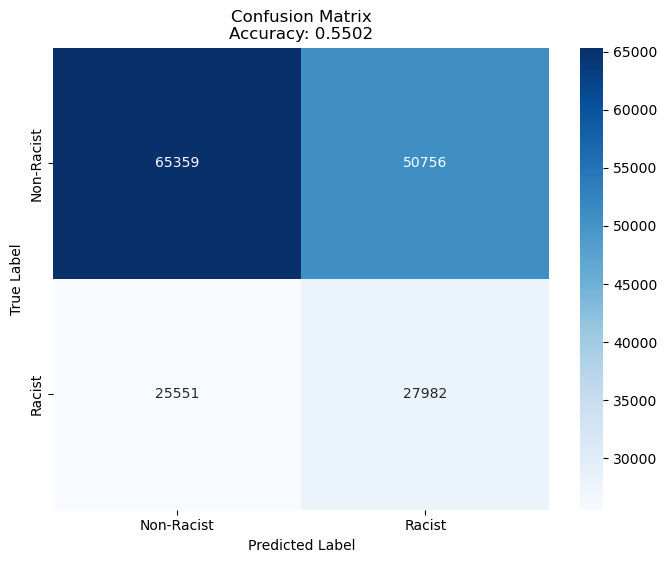

In [288]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score


# Calculate Accuracy and Confusion Matrix
accuracy = accuracy_score(kaggle['true_label'], kaggle['pred_label_binary'])
f1 = f1_score(kaggle['true_label'], kaggle['pred_label_binary'])
conf_matrix = confusion_matrix(kaggle['true_label'], kaggle['pred_label_binary'])

# Display the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

# Plot the Confusion Matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
ax = sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
                 xticklabels=["Non-Racist", "Racist"], yticklabels=["Non-Racist", "Racist"])
ax.set_title(f"Confusion Matrix\nAccuracy: {accuracy:.4f}")
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")
plt.show()